# Word 2 Vec

The following notebook walks you through using word2vec from the Python Gensim package. Word2Vec is a Word Embedding Model (WEM) and helps to find how specific words are used in a given text. 

###  Before we begin
Before we start, you will need to have set up a [Carbonate account](https://kb.iu.edu/d/aolp) in order to access [Research Desktop (RED)](https://kb.iu.edu/d/apum). You will also need to have access to RED through the [thinlinc client](https://kb.iu.edu/d/aput). If you have not done any of this, or have only done some of this, but not all, you should go to our [textPrep-Py.ipynb](https://github.com/cyberdh/Text-Analysis/blob/master/Python/Py_notebooks/textPrep-Py.ipynb) before you proceed further. The textPrepPy notebook provides information and resources on how to get a Carbonate account, how to set up RED, and how to get started using the Jupyter Notebook on RED. 

### Run CyberDH environment
The code in the cell below points to a module specificaly for use with the Python Jupyter Notebooks created by Cyberinfrastructure for Digital Humanities. It allows for the use of the different pakcages in our notebooks and their subsequent data sets.

##### Packages
- **sys:** Provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. It is always available.
- **os:** Provides a portable way of using operating system dependent functionality.

#### NOTE: This cell is only for use with Research Desktop. You will get an error if you try to run this cell on your personal device!!

In [1]:
import sys
import os
sys.path.insert(0,"/N/u/cyberdh/Carbonate/dhPyEnviron/lib/python3.6/site-packages")
os.environ["NLTK_DATA"] = "/N/u/cyberdh/Carbonate/dhPyEnviron/nltk_data"

### Include necessary packages for notebook 

Python's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of Python, others created by Python users are available for download. Make sure to have the following packages installed before beginning so that they can be accessed while running the scripts.

In your terminal, packages can be installed by simply typing "pip install nameofpackage --user" (minus the quotes).


- **re:** Provides regular expression matching operations similar to those found in Perl.
- **string:** Contains a number of functions to process standard Python strings.
- **nltk:** A leading platform for building Python programs to work with human language data.
- **glob:** Finds all the pathnames matching a specified pattern according to the rules used by the Unix shell.
- **numpy:** a general-purpose array-processing package designed to efficiently manipulate large multi-dimensional arrays of arbitrary records without sacrificing too much speed for small multi-dimensional arrays. 
- **pandas:** An open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
- **warnings:** Allows for the manipulation of warning messages in Python.
- **pprint:** Provides a capability to “pretty-print” arbitrary Python data structures in a form which can be used as input to the interpreter.
- **spacy:** A library for advanced Natural Language Processing in Python and Cython.
- **sklearn:** Simple and efficient tools for data mining and data analysis built on NumPy, SciPy, and matplotlib.
- **matplotlib:** Produces publication quality 2D graphics for interactive graphing, scientific publishing, user interface development and web application servers targeting multiple user interfaces and hardcopy output formats.
- **collections:** implements specialized container datatypes providing alternatives to Python?s general purpose built-in containers, dict, list, set, and tuple.
- **gensim:** Python library for topic modelling, document indexing and similarity retrieval with large corpora.


In [2]:
import re
from os.path import join, isfile, splitext
import string
import nltk
from nltk.corpus import stopwords
import glob
import numpy as np
import pandas as pd
import warnings
from pprint import pprint
import spacy
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter

import gensim
import gensim.corpora as corpora
import gensim.downloader as api
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import doc2vec
from gensim.models.phrases import Phrases, Phraser

This will ignore deprecation, user, and future warnings. All the warnings in this code are not concerning and will not break the code or cause errors in the results.

In [3]:
warnings.filterwarnings("ignore", category=UserWarning,
                        module = "gensim", lineno = 598)

warnings.filterwarnings("ignore", category=FutureWarning,
                        module = "gensim", lineno = 737)
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Getting your data

#### Directory where the data is stored
We simply list out the path to the directory where we can access the files or file we need. Note that we do not use any file names yet, just the path to the folder. This is because we may want to read in all the files in the directory, or just one. There are options below for doing both. We save the path as a variable named dataHome. Then we save a filepath that points to where we want any results saved. Again, there is no filename, just the path. We will add the name later. Lastly, we have a filepath pointing to a stopword list we have created ourselves. It is commented out at the moment, but if you wish to use your own stopword list, remove the '#' from the beginning of the last line.

In [4]:
homePath = os.environ["HOME"]
dataHome = os.path.join(homePath, "Text-Analysis-master", "data")
dataResults = os.path.join(homePath, "Text-Analysis-master", "Output")

### Set needed variables
This is where you will make some decisions about your data and set the necessary variables.

First, we need to determine what file type our data is saved as. You can find this by the file extension at the end of your files name. Right now we can only read in plain text files which end in '.txt' (minus the quotes), comma separated values files which in '.csv', and JSON files which end in '.json'. So where it says 'fileType =' inside the double quotes you need to put either ".txt", ".csv", or ".json" depending on what your data file type is.

The 'docLevel' variable is only for file types of '.txt' so if you have a '.csv' or '.json' you want to set it to **False** or it will cause problems in other parts of the code later since we do not keep track of file names for the .csv and .json files. If your data is in '.txt' format, then you need to determine if you want to separate your corpus by line or by document. If you want to separate by document, then set docLevel equal to **True**. If you want to separate a line at a time and have the line be it's own entity or 'document' then set docLevel equal to **False**. If you are running this on only one document, then setting docLevel equal to **False** is recommended.

The nltkStop is where you determine if you want to use the built in stopword list provided by the NLTK package. They provide stopword lists in multiple languages. If you wish to use this then set nltkStop equal to **True**. If you do not, then set nltkStop equal to **False**.

Lastly, customStop is for if you have a .txt file that contains additional stopwords that you would like to read in and have added to the existing stopWords list. You do *NOT* need to use the NLTK stopwords list in order to add your own custom list of stopwords. **NOTE: Your custom stopwords file needs to have one word per line as it reads in a line at a time and the full contents of the line is read in and added to the existing stopwords list.** If you have a list of your own then set customStop equal to **True**. If you do not have your own custom stopwords list then set customStop equal to **False**.

The docs and tweets variables do not need to have anything done as they are just empty lists that have elements added to them later.

In [5]:
fileType = ".txt"
docLevel = True
nltkStop = True
customStop = True
docs = []
tweets = []

### Stopwords
If you set *nltkStop* equal to **True** above then this will add the NLTK stopwords list to the empty list named *stopWords*.

If you need a different language, simply change 'english' (keep the quotes) in *stopWords.extend(stopwords.words('english'))* to the anglicized name of the language you wish to use (e.g. 'spanish' instead of 'espanol' or 'german' instead of 'deutsch'). If you wish to add additional words to the stopWords list, add the word in quotes to the list in *stopWords.extend(['the', 'words', 'you', 'want', 'to', 'add'])*.

If you need to see the list of available languages in nltk simply remove the '#' from in front of the last line and run the cell. A list of available languages will print out.

In [6]:
if nltkStop is True:
    # NLTK Stop words
    stopWords = []
    stopWords.extend(stopwords.words('english'))

    stopWords.extend(['would', 'said', 'says', 'also'])

    #print(" ".join(stopwords.fileids()))

#### Add own stopword list

Here is where your own stopwords list is added if you selected **True** in "customStop" above. Here you will need to change the folder names and file name to match your folders and file. Remember to put each folder name in quotes and in the correct order always putting the file name including the file extension (.txt) last.

In [7]:
if customStop is True:
    stopWordsFilepath = os.path.join(homePath, "Text-Analysis-master", "data", "earlyModernStopword.txt")

    with open(stopWordsFilepath, "r",encoding = 'utf-8') as f:
        stopWordsList = [x.strip() for x in f.readlines()]

    stopWords.extend(stopWordsList)

### Reading in .txt files
The code below reads in text files if you chose fileType *".txt"* above. It can do this in two ways. We can read in an entire directory, or we can read in a single file. Remember, LDA generally works best on larger datasets, so if you are uisng a single file it should be a large file and you should read it in a line at a time. In order to choose between an entire directory or a single file, look at the line of code that starts *paths =* (minus the quotes). Towards the end of the line where there is something in quotes directly preceding *+ fileType* is where you switch between the entire directory or a single file. To read in the entire directory simply put "\*" (this time with the quotes) and this will read all files that end in .txt. To read in a single file replace the "\*" with the file name of the file you are interested in like *"myText"*. 

The below code also lets you choose between reading your data in a file at a time or line by line. You made this choice up above by setting *docLevel* equal to **True** if you want to read in your data file by file, or to **False** if you want to read in your data line by line. You can make this choice whether you are reading in an entire directory or a single file. However, your research and data will determine whether line by line or file by file is best. If you are reading in a single file, it is highly recommended that you do line by line thereby making each line its own document. This should help with the accuracy of your results. 

In [8]:
if fileType == ".txt":
    paths = glob.glob(os.path.join(dataHome, "shakespeareFolger","*"+fileType))
    for path in paths:
            with open(path, "r", encoding = 'utf-8') as file:
                 # skip hidden file
                if path.startswith('.'):
                    continue
                if docLevel is True:
                    docs.append(file.read().strip('\n').splitlines())
                else:
                    for line in file:
                        stripLine = line.strip()
                        if len(stripLine) == 0:
                            continue
                        docs.append(stripLine.split())

### Reading in .csv files

If you chose *".csv"* as your *fileType* up above, then the code below reads in an entire directory of .csv files and saves the contents to a dataframe using the Pandas package. Then we choose the column in the dataframe we need and add each row in that column to a list. It is important that the .csv files contain similar data and identical column headers or you will get errors when the files are concatinated together. The last line is where you will name the column you wish to convert to a list. In between the square brackets you can either put the column header name with quotes around the name, or you can put the column number counting from left to right and starting with 0 instead of 1. If you wish to read in a single .csv file then replace the part in the first line of code that has "\*" with "filename" and this will read in the .csv file with that name from the directory.

In [9]:
if fileType == ".csv":
    all_files = glob.glob(os.path.join(dataHome, "Twitter", "*" + fileType))     
    df_all = (pd.read_csv(f) for f in all_files)
    cc_df = pd.concat(df_all, ignore_index=True)
    cc_df = pd.DataFrame(cc_df, dtype = 'str')
    tweets = cc_df['text'].values.tolist()

### Reading in JSON files

If you chose *".json"* as your *fileType* up above, then the code below reads in an entire directory of .json files and saves the contents to a dataframe using the Pandas package. Then we choose the column in the dataframe we need and add each row in that column to a list. It is important that the .json files contain similar data and identical keys or you will get errors when the files are concatinated together. The second to last line is where you will name the column in the dataframe you wish to convert to a list. In between the square brackets you can either put the column header name with quotes around the name, or you can put the column number counting from left to right and starting with 0 instead of 1. If you wish to read in a single .json file then replace the part in the first line of code that has "\*" with "filename" and this will read in the .json file with that name from the directory.

In [10]:
if fileType == ".json":
    for filename in glob.glob(os.path.join(dataHome, "Twitter", "*" + fileType)):
        with open(filename, 'r', encoding = "utf-8") as jsonData:
            for line in jsonData:
                tweets.append(json.loads(line))
    df = pd.DataFrame(tweets)
    tweets = df['text'].tolist()            
    print(len(df))

### Data variable

Now we need to change our variable containing our data (either docs or tweets from above) to the variable "data" since this is the variable used going forward and it saves you from having to switch between *tweets* and *docs* later in the code. If you read in .csv or .json files then your data is saved in the *tweets* list and if you read in .txt files then it is in the *docs* list. This code says if the length of the *docs* list is greater than or equal to 1 then change *docs* to the variable data. If the length of *docs* is not greater than or equal to 1 then change *tweets* to the variable *data*.

If your data was in tweets then it most likely needs soem additional cleaning. So the next chunk of code removes URLS and new line characters from the *data* variable if the length of *tweets* is greater than or equal to 1.

The last line simply prints out the first chunk of data in our collection, in this case the first 10 items. This can be 10 whole text files or 10 lines depending on your previous choices.

In [11]:
if len(docs) > 0:
    data = docs
else:
    if len(tweets) > 0:
        data = tweets
        # Remove Urls
        data = [re.sub(r'http\S+', '', sent) for sent in data]
        # Remove new line characters
        data = [re.sub('\s+', ' ', sent) for sent in data]
pprint(data[:10])

[[' In delivering my son from me, I bury a second',
  ' husband.',
  ' And I in going, madam, weep over my',
  " father's death anew; but I must attend his Majesty's",
  ' command, to whom I am now in ward, evermore',
  ' in subjection.',
  ' You shall find of the King a husband, madam;',
  ' you, sir, a father. He that so generally is at all times',
  ' good must of necessity hold his virtue to you,',
  ' whose worthiness would stir it up where it wanted',
  ' rather than lack it where there is such abundance.',
  " What hope is there of his Majesty's",
  ' amendment?',
  ' He hath abandoned his physicians, madam,',
  ' under whose practices he hath persecuted time',
  ' with hope, and finds no other advantage in the',
  ' process but only the losing of hope by time.',
  ' This young gentlewoman had a father -- O,',
  " that had, how sad a passage 'tis! -- whose skill",
  ' was almost as great as his honesty; had it stretched',
  ' so far, would have made nature immortal, and',
  ' de

### Tokenizing

This block of code separates each chunk of text in a list of individual words. In the process it also lower cases all the words and removes punctuation. If you wish to keep the punctuation change "deacc = True" to "deacc = False".

In [12]:
def sentToWords(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

dataWords = list(sentToWords(data))

print(dataWords[:1])

[['in', 'delivering', 'my', 'son', 'from', 'me', 'bury', 'second', 'husband', 'and', 'in', 'going', 'madam', 'weep', 'over', 'my', 'father', 'death', 'anew', 'but', 'must', 'attend', 'his', 'majesty', 'command', 'to', 'whom', 'am', 'now', 'in', 'ward', 'evermore', 'in', 'subjection', 'you', 'shall', 'find', 'of', 'the', 'king', 'husband', 'madam', 'you', 'sir', 'father', 'he', 'that', 'so', 'generally', 'is', 'at', 'all', 'times', 'good', 'must', 'of', 'necessity', 'hold', 'his', 'virtue', 'to', 'you', 'whose', 'worthiness', 'would', 'stir', 'it', 'up', 'where', 'it', 'wanted', 'rather', 'than', 'lack', 'it', 'where', 'there', 'is', 'such', 'abundance', 'what', 'hope', 'is', 'there', 'of', 'his', 'majesty', 'amendment', 'he', 'hath', 'abandoned', 'his', 'physicians', 'madam', 'under', 'whose', 'practices', 'he', 'hath', 'persecuted', 'time', 'with', 'hope', 'and', 'finds', 'no', 'other', 'advantage', 'in', 'the', 'process', 'but', 'only', 'the', 'losing', 'of', 'hope', 'by', 'time', 't

### Find Bigrams and Trigrams

This code will most likely not need to be adjusted. It creates a model of bigrams and trigrams in your dataset that occur frequently and then connect them with an underscore so the Word2Vec algorithm will later consider them as one word. This is a good idea for items like 'new york' or 'new zealand' or 'Ho Chi Minh'. If we do not combine these frequently occuring phrases then 'new' and 'york' will be considered independently and give us less accurate results. 

Right now we have a min_count of 5 and a threshold of 100. The min_count is simply the minimum number of times the bigram or trigram needs to occur in order to be combined with an underscore. The threshold is a score that the bigram or trigram needs to exceed in order to be combined with an underscore. The threshold score is determined by using this formula: (bigram_count - min_count)\*vocab_count/(wordA_count \* wordB_count). So let's say we have the bigram good_lord and it appears 30 times in a text of 10,000 words where "good" appears 60 times total and "lord" appears 40. With our minimum count set to 5 we get the following: (30 - 5)\*10000/(60 \* 40) = 104.167 which means since our threshold is set to 100 "good_lord" will be combined with an underscore and made into a bigram. If the resulting score is above your threshold then the ngram is considered important enough to combine with an underscore and will be viewed as one word for the Word2Vec algorithm later. Therefore, if you increase the threshold, you will get fewer bigrams and trigrams. If our threshold was set to 110, then "good" and "lord" would not be combined into "good_lord".

The Phraser function takes the model you built with the Phrases function and cuts down memory consumption of Phrases, by discarding model state not strictly needed for the bigram detection task.

Lastly, we take a look at the ngrams created from the first item in our dataset only, so the results are for only one chunk, not the whole dataset. We do this by counting the number of words that contain an underscore as this is used to connect the words in the ngram together. **NOTE:** The output is only to test if the ngrams work so you will probably see ngrams containing stopwords. We will create a few functions next and then apply them to remove stopwords, create bigrams, and lemmatize the chunk.

In [13]:
# Build the bigram and trigram models
bigram = Phrases(dataWords, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[dataWords], threshold=100)  

# Removes model state from Phrases thereby reducing memory use.
bigramMod = Phraser(bigram)
trigramMod = Phraser(trigram)

# See bigram/trigram example
testNgram = trigramMod[bigramMod[dataWords[0]]]
char = "_"
nGrams = [s for s in testNgram if char in s]
            
pprint(Counter(nGrams))

Counter({'count_rossillion': 10,
         'take_heed': 3,
         'twenty_times': 2,
         'an_ass': 2,
         'humbly_thank': 2,
         'ten_times': 1,
         'latter_end': 1,
         'eldest_son': 1,
         'thousand_crowns': 1,
         'chamber_window': 1,
         'two_months': 1,
         'both_sides': 1,
         'fee_simple': 1,
         'good_morrow': 1,
         'humble_bee': 1,
         'med_cine': 1,
         'stand_aside': 1})


### Some cleaning functions

Below are functions we are creating that perform certain tasks. First we are creating a function to remove the stopwords that are in our stopword list we created previously. Then we create functions to apply our bigram and trigram code from above. Lastly we create a lemmatization function. What is lemmatization? Well, in our case we are using it to tag words as nouns, adjectives, verbs, or adverbs. A lemmatizer can also conjugate verbs and decline nouns into their root or infinitive/nominative form. This can be useful in topic modeling as the terms run, running, and ran will be changed to 'run' so you know if the idea of 'running' in general is a part of a topic. At the moment the lemmatizer is commented out. To use it remove the '#' from in front of all the bottom lines.

In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def removeStopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopWords] for doc in texts]

def makeBigrams(texts):
    return [bigramMod[doc] for doc in texts]

def makeTrigrams(texts):
    return [trigramMod[bigramMod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    textsOut = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        textsOut.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return textsOut

Now we apply the cleaning functions. There is really only one part where you will need to make changes and that is in the line nlp = spacy.load('en', disable=\['parser', 'ner'\]). This line of code determines what language you want to use for lemmatization and also disables the parser and named entity recognizer (ner). The languages available for spacy include the list below and to download them you need to open your temrinal and type in the following:

##### NOTE: The following are for Research Desktop use. If using on your own machine remove --user from the end. Also, if using an Anaconda installed version of Python 3 on your own machine do not add the 3 to python, should simply be "python -m spacy download en" (minus the quotes).

- **English:** python3 -m spacy download en --user
- **Spanish:** python3 -m spacy download es --user
- **German:** python3 -m spacy download de --user
- **French:** python3 -m spacy download fr --user
- **Italian:** python3 -m spacy download it --user
- **Portuguese:** python3 -m spacy download pt --user
- **Dutch:** python3 -m spacy download nl --user
- **Multi-Language:** python3 -m spacy download xx --user

To choose a language simply type the two letter code you just used to download the language in between the single quotes where it says 'en'. So for Spanish it would be 'es' (with the quotes) and for German 'de' and so on.

If you wish for your words to be parsed simply remover 'parser' (with the quotes) from the "disable=" bracket. Same for ner. If you wish to use both the parser and ner then just remove the ", disable=\['parser', 'ner'\]" entirely (including the preceding comma).

The lemmatizer is currently commented out. To use it remove the "#" from in front of the 'nlp' and the 'data_lemmatized'. If you do also change the last line from "print(data_words_bigrams[:1])" to "print(data_lemmatized[:1])".

In [15]:
# Remove Stop Words
dataWordsNostops = removeStopwords(dataWords)

# Form Bigrams
dataWordsNgrams = makeBigrams(dataWordsNostops)

nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
dataLemmatized = lemmatization(dataWordsNgrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(dataLemmatized[:1])

[['deliver', 'son', 'bury', 'second', 'husband', 'go', 'madam', 'weep', 'father', 'death', 'anew', 'attend', 'majesty', 'command', 'ward', 'evermore', 'subjection', 'king', 'husband', 'madam', 'father', 'generally', 'time', 'good', 'necessity', 'hold', 'virtue', 'worthiness', 'stir', 'want', 'lack', 'abundance', 'hope', 'majesty', 'amendment', 'abandon', 'physician', 'madam', 'practice', 'persecute', 'time', 'hope', 'find', 'advantage', 'process', 'lose', 'hope', 'time', 'young', 'gentlewoman', 'father', 'sad', 'passage', 'skill', 'great', 'honesty', 'stretch', 'far', 'nature', 'immortal', 'death', 'play', 'lack', 'work', 'king', 'sake', 'living', 'think', 'death', 'king', 'disease', 'call', 'man', 'speak', 'madam', 'famous', 'profession', 'great', 'right', 'gerard', 'narbon', 'excellent', 'madam', 'king', 'lately', 'speak', 'admiringly', 'mourningly', 'skillful', 'lived', 'knowledge', 'set', 'mortality', 'good', 'lord', 'king', 'languish', 'fistula', 'lord', 'hear', 'notorious', 'gent

#### Getting Information
Now we save our cleaned corpus as the variable 'texts'. If you did not use the lemmatizer above remember to change "dataLemmatized" to "dataWordsBigrams".

Then we combine our list of lists into a single list. Next, we import the Counter function from the collections package and then use it to count how often every word appears in our cleaned and finalized list of words and ngrams.

Now we print out the number of total words, followed by the number of unique words, and ending with the top 1000 words based on frequency. You will want to change this number based on the size of your dataset.  

In [16]:
# Create Corpus
texts = dataLemmatized
tokens = sum(texts, [])

from collections import Counter
count = Counter(tokens)
print(sum(count.values()))
print(len(count))
print(count.most_common(1000))

311478
16011
[('come', 3630), ('good', 3042), ('lord', 3038), ('man', 2875), ('love', 2470), ('let', 2363), ('know', 2305), ('make', 2027), ('say', 1750), ('king', 1568), ('speak', 1551), ('think', 1413), ('tell', 1352), ('hear', 1302), ('time', 1218), ('heart', 1147), ('look', 1141), ('hand', 1118), ('father', 1087), ('god', 1045), ('great', 1026), ('eye', 1009), ('day', 928), ('word', 907), ('life', 905), ('bear', 904), ('death', 889), ('leave', 889), ('art', 885), ('friend', 875), ('master', 845), ('stand', 815), ('lie', 810), ('fair', 783), ('live', 779), ('true', 777), ('sweet', 775), ('son', 772), ('go', 772), ('lady', 770), ('pray', 770), ('fear', 763), ('away', 726), ('honour', 717), ('brother', 712), ('die', 689), ('bring', 673), ('night', 669), ('blood', 661), ('mean', 655), ('noble', 655), ('world', 652), ('grace', 637), ('hold', 626), ('old', 620), ('way', 615), ('poor', 613), ('head', 604), ('see', 593), ('show', 583), ('send', 571), ('woman', 571), ('hast', 568), ('give',

### Build vocabulary and train the model
Now we pass our corpus through the Word2Vec function. Then we call the function 'train' to train word2vec using our corpus. The settings in the Word2Vec function may need to be changed depending on your needs and your dataset and they do the following:

- **texts:** Is simply passing our variable above and letting Word2Vec know that this is what we wish to use for our dataset.
- **size:** The size of the dense vector to represent each token or word (i.e. the context or neighboring words). If you have limited data, then size should be a much smaller value since you would only have so many unique neighbors for a given word. If you have lots of data, its good to experiment with various sizes.
- **window:** The maximum distance between the target word and its neighboring word. If your neighbor's position is greater than the maximum window width to the left or the right, then, some neighbors would not be considered as being related to the target word. In theory, a smaller window should give you terms that are more related.
- **min_count:** Minimum number of times a word needs to appear to be counted. This should be adjusted based on your dataset.
- **workers:** How many cores to use on a machine with multiple cores.
- **seed:** Sets the seed for reproducibility

In [17]:
# build vocabulary and train model

model = gensim.models.Word2Vec(
    texts,
    size=100,
    window=10,
    min_count=100,
    workers=1,
    seed = 42)
model.train(texts, total_examples=len(texts), epochs=10)

(1480040, 3114780)

### Let's find some word relationships
Now we choose a word of interest and see what other words are associated with that word in the text. Simply change the word in quotes after w1 to change the word. You may also want to change the topn value as this determines how of the top words you will get in the .csv file output. You will also want to change the name of the file to better match your data.

In [18]:
w1 = "man"
w2 = "king"
w3 = "woman"
wtv = model.wv.most_similar(positive=[w1], topn = 30)
df = pd.DataFrame(wtv)
df.to_csv(os.path.join(dataResults, 'word2vec.csv'))
df[:10]

,0,1
0,beast,0.688828
1,honest,0.615961
2,truly,0.539748
3,eat,0.533727
4,knave,0.518076
5,woman,0.498196
6,old,0.496821
7,beard,0.494266
8,yea,0.485576
9,ass,0.480360


Here we can compare two words to each other to see how similar they are in their usage. Just change the words in quotes to the ones you want to compare.

In [19]:
model.wv.similarity(w1 = 'king', w2 = 'queen')

0.59689766

Now we create a function that uses t-SNE for dimensionality reduction to produce a scatter plot showing where the words from our word2vec appear as vectors in a 2 dimensional space. 

Any changes you might want to make would be in the "tsne_model =" line as you may wish to adjust the perplexity, number of components, the init, the number of iterations, or the random_state.

- **perplexity:** The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. The choice is not extremely critical since t-SNE is quite insensitive to this parameter.
- **n_components:** Dimension of the embedded space.
- **init:** Initialization of embedding. Possible options are 'random', 'pca', and a numpy array of shape (n_samples, n_components). PCA initialization cannot be used with precomputed distances and is usually more globally stable than random initialization. Random also works better on a dense dataset.
- **n_iter:** Maximum number of iterations for the optimization. Should be at least 250.
- **random_state:** The seed used by the random number generator. Allows for reproducibility of the output. If none, then the random number generator is the RandomState instance used by np.random, so it will be different every time if no seed number is given.

You might also want to make adjsutments to the figsize depending on your data.

In [20]:
def tsnePlot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsneModel = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
    newValues = tsneModel.fit_transform(tokens)

    x = []
    y = []
    for value in newValues:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.savefig(os.path.join(dataResults, "scatterPlot.png"), dpi = 300)
    plt.show()

Now plot the t-SNE scatter plot of all the word vectors from our word2vec to get a sense of what words are closer together in the vector space.

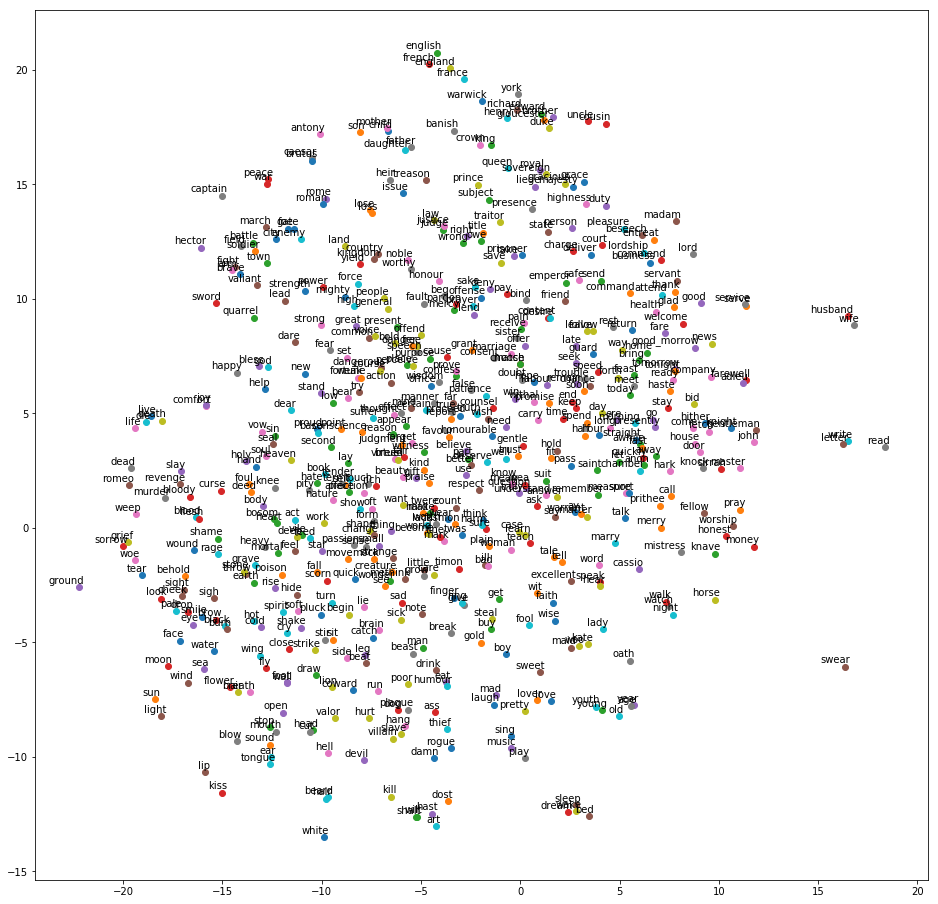

In [21]:
tsnePlot(model)

## VOILA!!

This code was adapted from Kavita Ganesan at [http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.XFnQmc9KjUI](http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.XFnQmc9KjUI). Accessed 02/05/2019. The tsne_plot function was taken entirley from https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne/notebook and was accessed on 02/25/2019.